In [ ]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
#######################################
###!@1 START OF PYSPARK INIT
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT
###!@0 END INIT ENVIRONMENT

Mounted at /content/drive


In [ ]:
#All the necessary import statements
from pyspark.sql.functions import col, lower
import matplotlib.pyplot as plt
from functools import reduce
from pyspark.sql import DataFrame
import pandas as pd
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DoubleType
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import col


def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)



In [ ]:
years = ["2017_2018", "2018_2019", "2019_2020"]
SouthStates = ["AndhraPradesh", "Karnataka", "Kerala", "TamilNadu", "Telangana"]
basePath = "/content/drive/Shareddrives/DataEngineeringProject/SouthDistricts/"
"""
  Method to read the data for a particular state on particular time period (current default : 2019_2020)
  Drops all the unnecessary columns and replaces nulls with 0 and returns the data
"""
def readAllDataForState(state, year="2019_2020"):
  path = basePath + year + "/" + state + "/*.csv"
  data = spark.read.option("header",True).option("inferSchema",True).csv(path)
  colsNotRequired = ("Building", "Boundary_Wall", "Single_Class_Room",\
                     "Separate_Room_for_Headmaster", "Land_Available", "Electricity",\
                      "Furniture", "Librarian", "Boy_Toilet", "Girl_Toilet", "Drinking_Water")
  data.drop(*colsNotRequired)
  data.na.fill(0)
  return data

import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def showCorrelation(x, y, xlab="", ylab=""):
  plt.figure()
  # adds the title
  plt.title('Correlation')
    
  # plot the data
  plt.scatter(x, y)
    
  # fits the best fitting line to the data
  plt.plot(np.unique(x), 
          np.poly1d(np.polyfit(x, y, 1))
          (np.unique(x)), color='red')
    
  # Labelling axes
  plt.xlabel(xlab)
  plt.ylabel(ylab)

**Load SSLC Performance Data for years 2017, 2018, 2019**

This data contains the pass percentage of students in SSLC District-wise

Obtained from the below sources

https://sslc.karnataka.gov.in/new-page/Result%20Statistics/en

https://www.careerindia.com/news/karnataka-sslc-pass-percentage-district-wise-list-030178.html?story=2


In [ ]:

path = "/content/drive/Shareddrives/DataEngineeringProject/SouthDistricts/KarnatakaPerformance_17_18_19.csv"
data = spark.read.option("header",True).option("inferSchema",True).csv(path)
data17 = data.withColumn('Districts1', lower(col("Districts1"))).select("Districts1", "2017").withColumnRenamed("Districts1", "District_Name").sort("District_Name")
data18 = data.withColumn('Districts2', lower(col("Districts2"))).select("Districts2", "2018").withColumnRenamed("Districts2", "District_Name").sort("District_Name").\
withColumn("District_Name", regexp_replace('District_Name', 'bagalkot', 'bagalkote'))
data19 = data.withColumn('Districts3', lower(col("Districts3"))).select("Districts3", "2019").withColumnRenamed("Districts3", "District_Name").sort("District_Name")
allYearsData = data17.join(data18, ["District_Name"]).join(data19, ["District_Name"])
allYearsData = allYearsData.withColumn("2018", allYearsData["2018"].cast(DoubleType()))

#Handling Data Mismatch in the 3rd party data
renameList = [("bagalkote", "bagalkot"), ("chikodi", "belagavi chikkodi"), ("bengaluru north", "bengaluru u north"),
              ("bengaluru south","bengaluru u south"), ("chamarajanagar","chamarajanagara"), ("chikkaballapur","chikkaballapura"),
              ("chikkamagaluru","chikkamangaluru"), ("kalaburagi","kalburgi"), ("madhugiri","tumakuru madhugiri"),
              ("ramnagara","ramanagara"), ("sirsi","uttara kannada sirsi"), ("yadgir","yadagiri")]

for item in renameList:
  allYearsData = allYearsData.withColumn("District_Name", regexp_replace('District_Name', item[0], item[1]))

**Facilities data of Karnataka for the year 2017, 2018, 2019**

In [ ]:
import pyspark.sql.functions as psf
from pyspark.sql.functions import col
from pyspark.sql.types import StructType

data = readAllDataForState("Karnataka")
# get all states to a single dataframe with facility data
def get_facilities(states = SouthStates, data = None):
  columns = ["State_Name", "District_Name", "Total_Number_of_Schools", "Functional_Electricity", "Playground", "Library_or_Reading_Corner_or_Book_Bank", "Newspaper", "Functional_Boy_Toilet", "Functional_Girl_Toilet", "Functional_Toilet_Facility", "Functional_Urinal_Boy", "Functional_Urinal_Girl", "Functional_Urinal" , "Functional_Toilet_and_Urinal", "Functional_Drinking_Water", "Water_Purifier", "Handwash", "Ramps", "Internet", "Computer_Available"]

  all_facilities = data

  if all_facilities == None: # retrieve dara
    for state in states:
      currStateData = readAllDataForState(state).select([col for col in columns])
      
      if all_facilities == None:
        all_facilities = currStateData
      else:
        all_facilities = currStateData.union(all_facilities)
  else: # probably synthetic
    all_facilities = data.select([col for col in columns])

  return all_facilities

def essentials_schoolper_state(states = SouthStates, data = None):
  columns = ['State_Name', 'District_Name', 'Total_Number_of_Schools', 'Functional_Drinking_Water', 'Functional_Boy_Toilet', 'Functional_Girl_Toilet', \
             'Handwash', 'Functional_Electricity', 'Newspaper', 'Library_or_Reading_Corner_or_Book_Bank', 'Playground', 'Internet', 'Computer_Available', 'Ramps']
  answer = {}
  # get facility list of all states
  essential_df = get_facilities(states, data).select([col for col in columns])
  essential_df1 = essential_df.groupBy("State_Name", "District_Name").agg(psf.sum('Total_Number_of_Schools').alias('Total_Number_of_Schools'), \
                                                         psf.sum('Functional_Drinking_Water').alias('Functional_Drinking_Water'), \
                                                         psf.sum('Functional_Boy_Toilet').alias('Functional_Boy_Toilet'), \
                                                         psf.sum('Functional_Girl_Toilet').alias('Functional_Girl_Toilet'), \
                                                         psf.sum('Handwash').alias('Handwash'), \
                                                         psf.sum('Functional_Electricity').alias('Functional_Electricity'), \
                                                         psf.sum('Newspaper').alias('Functional_Newspaper'), \
                                                         psf.sum('Library_or_Reading_Corner_or_Book_Bank').alias('Library_or_Reading_Corner_or_Book_Bank'), \
                                                         psf.sum('Playground').alias('Playground'),\
                                                         psf.sum('Ramps').alias('Ramps'),\
                                                         psf.sum('Internet').alias('Internet'), \
                                                         psf.sum('Computer_Available').alias('Computer_Available'))
  fields = essential_df1.schema.fields
  for col in fields:
    if str(col.dataType) is not "StringType":
      if col.name == 'Total_Number_of_Schools':
        continue
      essential_df1 = essential_df1.withColumn(col.name, (100 * \
                                                     (1 - ((essential_df1['Total_Number_of_Schools'] - essential_df1[col.name]) / essential_df1['Total_Number_of_Schools']))).cast(IntegerType()))
  essential_df1 = essential_df1.drop('Total_Number_of_Schools')
  answer['names'] = essential_df1.columns
  answer['values'] = [list(row) for row in essential_df1.collect()]

  return essential_df1, answer

In [ ]:
features = ['Functional_Drinking_Water', 'Functional_Boy_Toilet', 'Functional_Girl_Toilet','Handwash',
            'Functional_Electricity', 'Functional_Newspaper', 'Library_or_Reading_Corner_or_Book_Bank', 'Playground',
            'Internet', 'Computer_Available', 'Ramps']

yearWiseData = {}
for year in years:
  data = readAllDataForState("Karnataka", year)
  ans = essentials_schoolper_state(["Karnataka"], data)
  all_facilities_Ka = ans[0]
  all_facilities_Ka = all_facilities_Ka.drop("State_Name")
  all_facilities_Ka = all_facilities_Ka.withColumn('District_Name', lower(col("District_Name")))
  yearWiseData[year] = all_facilities_Ka.join(allYearsData, ["District_Name"])

In [ ]:
years = ["2019_2020"]
maxCorrelationFeature = ""
minCorrelationFeature = ""
max = -2
min = 2

for year in years:
  print(year)
  for feature in features:
    corrVal = yearWiseData[year].stat.corr(feature, year.split("_")[0])
    if corrVal > max:
      max = corrVal
      maxCorrelationFeature = feature
    if corrVal < min:
      min = corrVal
      minCorrelationFeature = feature
    print(feature + " : Correlation --> " + str(corrVal))

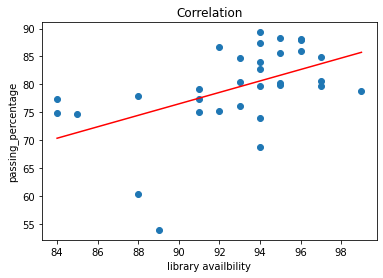

In [ ]:
reducedData = yearWiseData["2019_2020"].select("Library_or_Reading_Corner_or_Book_Bank", "2019")
reducedData = reducedData.toPandas()
x = reducedData["Library_or_Reading_Corner_or_Book_Bank"]
y = reducedData["2019"]
showCorrelation(x,y, "library availbility", "passing_percentage")

**Build and obtain the Hygiene Score of Karnataka**

In [ ]:
def buildHygieneScoreGetTop10(states, data):
  global index
  answer = {}
  
  for state in states:
    stateData = data[state]
    stateData = stateData.select("State_Name", "District_Name", "Total_Number_of_Schools", "Functional_Toilet_Facility", "Functional_Urinal", "Functional_Drinking_Water", "Water_Purifier", "Water_Tested", "Handwash")
    stateData = stateData.withColumn("HygieneScoreAvg", F.expr("(100 * ((Functional_Drinking_Water * 0.25) +\
                                                                  (Water_Purifier * 0.25) +\
                                                                  (Functional_Toilet_Facility * 0.25) +\
                                                                  (Handwash * 0.15) +\
                                                                  (Functional_Urinal * 0.05) +\
                                                                  (Water_Tested * 0.05)) / Total_Number_of_Schools)"))
    
    stateData = stateData.groupBy("State_Name", "District_Name").avg("HygieneScoreAvg").withColumnRenamed("avg(HygieneScoreAvg)", "HygieneScore")
    answer[state] = stateData
  return answer


In [ ]:
yearWiseData = {}
data = {}
for year in years:
  data["Karnataka"] = readAllDataForState("Karnataka", year)
  all_districts_HygieneScore = buildHygieneScoreGetTop10(["Karnataka"], data)
  all_districts_HygieneScore = all_districts_HygieneScore["Karnataka"]
  all_districts_HygieneScore = all_districts_HygieneScore.drop("State_Name")
  all_districts_HygieneScore = all_districts_HygieneScore.withColumn('District_Name', lower(col("District_Name")))
  yearWiseData[year] = all_districts_HygieneScore.join(allYearsData, ["District_Name"])

**Check correlation of the performance with Hygiene Score**

2017_2018  :  0.3689486295083804
2019_2020  :  0.3553997957870792


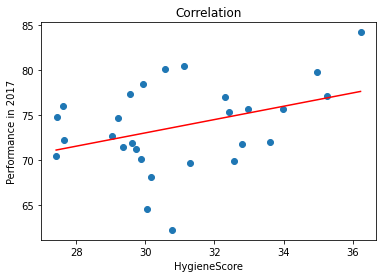

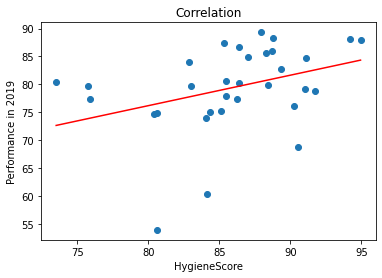

In [ ]:
years = ["2017_2018", "2019_2020"]
for year in years:
  corrVal = yearWiseData[year].stat.corr("HygieneScore", year.split("_")[0])
  print(year, " : " ,corrVal)
  
for year in years:
  ylab = year.split("_")[0]
  reducedData = yearWiseData[year].select("HygieneScore", ylab)
  reducedData = reducedData.withColumn("HygieneScore", reducedData["HygieneScore"].cast(DoubleType()))
  reducedData = reducedData.toPandas()
  x = reducedData["HygieneScore"]
  y = reducedData[ylab]

  showCorrelation(x,y, "HygieneScore", "Performance in " + ylab)